In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [8]:
params_dict_mu = {
    'input_size': 3,
    'hidden_size': 10,
    'output_size': 3,
    'ode_nn': ((50, "tanh"), (50, "tanh")),
    'readout_nn': ((50, "tanh"), (50, "tanh")),
    'enc_nn': ((50, "tanh"), (50, "tanh")),
    'use_rnn': False,
    'options': {'which_loss': 'easy'},
    "input_coords": np.arange(3),
    "output_coords": np.arange(3),
    "signature_coords": np.arange(3)
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from models import get_ckpt_model, NJODE
model_mu = NJODE(**params_dict_mu).to(device)
optimizer = torch.optim.Adam(model_mu.parameters())
get_ckpt_model("../data/saved_models/id-57/best_checkpoint/", model_mu, optimizer, device)
model_mu.eval()

using loss: easy
neuralODE use input scaling with tanh
use residual network: input_size=3, output_size=10
use residual network: input_size=10, output_size=3


NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=15, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
 

In [9]:
params_dict_vol = {
    'input_size': 9,
    'hidden_size': 10,
    'output_size': 9,
    'ode_nn': ((50, "tanh"), (50, "tanh")),
    'readout_nn': ((50, "tanh"), (50, "tanh")),
    'enc_nn': ((50, "tanh"), (50, "tanh")),
    'use_rnn': False,
    'options': {'which_loss': 'easy_vol'},
    "input_coords": np.arange(9),
    "output_coords": np.arange(9),
    "signature_coords": np.arange(9)
}
model_vol = NJODE(**params_dict_vol).to(device)
optimizer_vol = torch.optim.Adam(model_vol.parameters())
get_ckpt_model("../data/saved_models/id-54/last_checkpoint/", model_vol, optimizer_vol, device)
model_vol.eval()

using loss: easy_vol
neuralODE use input scaling with tanh
use residual network: input_size=9, output_size=10
use residual network: input_size=10, output_size=9


NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=21, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=9, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
 

In [10]:
mu_data=np.load("../data/training_data/OrnsteinUhlenbeckMultiDimensional-46/data.npy")

In [11]:
 def generate_next_value( X_t, mu_t, sigma_t, delta_t):
    """
    Generate the next value in the time series using the Euler-Maruyama scheme.

    :param X_t: current value tensor of shape (batch_size, d)
    :param mu_t: drift coefficient tensor of shape (batch_size, d)
    :param sigma_t: diffusion coefficient tensor of shape ( d, d)
    :param delta_t: time difference float
    :return: next value tensor of shape (batch_size, d)
    """
    delta_Wt = torch.randn_like(X_t) * np.sqrt(delta_t)

    X_t_next = X_t + mu_t * delta_t + delta_Wt @ sigma_t

    return X_t_next

In [12]:
import data_utils

In [13]:
dataset_metadata = data_utils.load_metadata(stock_model_name="OrnsteinUhlenbeckMultiDimensional", time_id=46)
stockmodel = data_utils._STOCK_MODELS[dataset_metadata['model_name']](**dataset_metadata)

In [14]:
def next_cond_exp( y, delta_t, speed, mean):
    exp_delta = torch.matrix_exp(-speed * delta_t)
    return y @ exp_delta + mean @ (torch.eye(3) - exp_delta)

In [15]:
speed = torch.tensor([[0.3, 0, 0], [0, 0.3, 0], [0, 0, 0.3]], dtype=torch.float)
mean = torch.tensor([[1.2, 1.0, 1.5]], dtype=torch.float)

In [22]:
times=np.array([])
time_ptr = np.array([0])
obs_idx = torch.tensor([],dtype=torch.long)
start_Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
delta_t=0.01
X= torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
start_X = torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
n_obs_ot=torch.tensor([0], dtype=torch.float)


first_term = torch.tensor([], dtype=torch.float)
second_term = torch.tensor([], dtype=torch.float)
third_term = torch.tensor([], dtype=torch.float)


X_cond_true = torch.tensor([], dtype=torch.float)
X_cond_model = torch.tensor([], dtype=torch.float)
X_cond = torch.tensor([], dtype=torch.float)
for i in range(1, 4):

    T=delta_t*i
    mu_pred=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1]
    X_cond_model = torch.cat((X_cond_model, mu_pred))
    print(model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot))

    if torch.isnan(mu_pred).any():
        break
        #print(model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot))
    X_t = X[i-1,:].unsqueeze(0)
    if i>1:
        X_t_minus = X[i-2, :].unsqueeze(0)
        Z_tensor = (X_t - X_t_minus).T@(X_t-X_t_minus)
        Z=torch.cat((Z,Z_tensor.view(1,-1)))
    #print(Z)

    X_cond_true = torch.cat((X_cond_true, torch.tensor(stockmodel.next_cond_exp(X_t.detach().numpy(),delta_t,T), dtype=torch.float)))
    X_cond = torch.cat((X_cond,next_cond_exp(X_t, delta_t, speed, mean)))
    sigma_pred=model_vol.get_pred(times, time_ptr, Z, obs_idx, delta_t, T, start_Z, n_obs_ot )["pred"][-1]

    #print(model_vol.get_pred(times, time_ptr, Z, obs_idx, delta_t, T, start_Z, n_obs_ot ))
    mu_hat_t = (mu_pred - X_t)/delta_t
    sigma_hat_t = sigma_pred.view(3,3)/np.sqrt(delta_t)




    first_term = torch.cat((first_term,X_t))
    second_term = torch.cat((second_term,mu_hat_t*delta_t))
    third_term = torch.cat((third_term,torch.randn_like(X_t)@sigma_hat_t*np.sqrt(delta_t)))
    #X_next = X_t +  mu_hat_t*delta_t + torch.randn_like(X_t)@sigma_hat_t*np.sqrt(delta_t)

    #X_next = generate_next_value(X_t, mu_hat_t, sigma_hat_t, delta_t)
    #print(X_next, X_t, mu_hat_t*delta_t,  torch.randn_like(X_t)@sigma_pred.view(3,3))

    X= torch.cat((X, torch.tensor(mu_data[0,:,i], dtype=torch.float).unsqueeze(0)))
    times=np.append(times, delta_t*i)
    time_ptr = np.append(time_ptr, i)
    obs_idx=torch.cat((obs_idx, torch.tensor([0], dtype=torch.long)))
    n_obs_ot+=1

{'pred': tensor([[[1.0001, 1.4999, 2.0001]],

        [[1.0002, 1.4994, 1.9995]]], grad_fn=<SliceBackward0>), 'pred_t': array([0.  , 0.01]), 'loss': tensor(0.)}
{'pred': tensor([[[1.0001, 1.4999, 2.0001]],

        [[1.0002, 1.4994, 1.9995]],

        [[1.0001, 1.4999, 2.0001]],

        [[1.0002, 1.4994, 1.9995]]], grad_fn=<SliceBackward0>), 'pred_t': array([0.  , 0.01, 0.01, 0.02]), 'loss': tensor(9.5534e-07, grad_fn=<AddBackward0>)}
{'pred': tensor([[[1.0001, 1.4999, 2.0001]],

        [[1.0002, 1.4994, 1.9995]],

        [[1.0001, 1.4999, 2.0001]],

        [[1.0002, 1.4994, 1.9995]],

        [[1.0498, 1.5353, 2.0486]],

        [[1.0499, 1.5348, 2.0480]]], grad_fn=<SliceBackward0>), 'pred_t': array([0.  , 0.01, 0.01, 0.02, 0.02, 0.03]), 'loss': tensor(0.0031, grad_fn=<AddBackward0>)}


In [23]:
X_cond_true

tensor([[1.0006, 1.4980, 1.9975],
        [1.0501, 1.5333, 2.0458],
        [1.1041, 1.5902, 2.0547]])

In [24]:
X_cond_model

tensor([[1.0002, 1.4994, 1.9995],
        [1.0002, 1.4994, 1.9995],
        [1.0499, 1.5348, 2.0480]], grad_fn=<CatBackward0>)

In [25]:
X_cond

tensor([[1.0006, 1.4985, 1.9985],
        [1.0501, 1.5338, 2.0469],
        [1.1041, 1.5908, 2.0559]])

In [58]:
times=np.array([])
time_ptr = np.array([0])
obs_idx = torch.tensor([],dtype=torch.long)
start_Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
delta_t=0.01
X= torch.tensor(np.array([1.0, 1.5, 2.0]), dtype=torch.float).unsqueeze(0)
start_X = torch.tensor(np.array([1.0, 1.5, 2.0]), dtype=torch.float).unsqueeze(0)
n_obs_ot=torch.tensor([0], dtype=torch.float)


first_term = torch.tensor([], dtype=torch.float)
second_term = torch.tensor([], dtype=torch.float)
third_term = torch.tensor([], dtype=torch.float)


X_cond_true = torch.tensor([], dtype=torch.float)
X_cond_model = torch.tensor([], dtype=torch.float)

for i in range(1, 3):
    
    T=delta_t*i
    mu_pred=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1]
    X_cond_model = torch.cat((X_cond_model, mu_pred))
    
                        
    if torch.isnan(mu_pred).any():
        break
        #print(model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot))
    X_t = X[i-1,:].unsqueeze(0)
    if i>1:
        X_t_minus = X[i-2, :].unsqueeze(0)
        Z_tensor = (X_t - X_t_minus).T@(X_t-X_t_minus)
        Z=torch.cat((Z,Z_tensor.view(1,-1)))
    #print(Z)

    X_cond_true = torch.cat((X_cond_true, torch.tensor(stockmodel.next_cond_exp(X_t.detach().numpy(),delta_t,T), dtype=torch.float)))   
    sigma_pred=model_vol.get_pred(times, time_ptr, Z, obs_idx, delta_t, T, start_Z, n_obs_ot )["pred"][-1]

    #print(model_vol.get_pred(times, time_ptr, Z, obs_idx, delta_t, T, start_Z, n_obs_ot ))
    mu_hat_t = (mu_pred - X_t)/delta_t
    sigma_hat_t = sigma_pred.view(3,3)/np.sqrt(delta_t)

   
    
   
    first_term = torch.cat((first_term,X_t))
    second_term = torch.cat((second_term,mu_hat_t*delta_t))
    third_term = torch.cat((third_term,torch.randn_like(X_t)@sigma_hat_t*np.sqrt(delta_t)))
    X_next = X_t +  mu_hat_t*delta_t + torch.randn_like(X_t)@sigma_hat_t*np.sqrt(delta_t)
    
    
    
    #X_next = generate_next_value(X_t, mu_hat_t, sigma_hat_t, delta_t)
    #print(X_next, X_t, mu_hat_t*delta_t,  torch.randn_like(X_t)@sigma_pred.view(3,3))

    X= torch.cat((X,X_next))
    times=np.append(times, delta_t*i)
    time_ptr = np.append(time_ptr, i)
    
    n_obs_ot+=1

In [59]:
X

tensor([[1.0000, 1.5000, 2.0000],
        [1.0470, 1.5503, 2.0867],
        [0.9930, 1.4870, 2.0025],
        [1.0303, 1.5350, 2.0816],
        [0.9703, 1.4580, 1.9608],
        [1.0491, 1.5464, 2.1243],
        [0.9493, 1.4385, 1.9460],
        [1.0520, 1.5537, 2.1008],
        [1.0301, 1.5047, 2.0378],
        [1.0489, 1.5777, 2.1424],
        [1.0381, 1.5029, 2.0456],
        [1.0466, 1.5888, 2.1378],
        [1.0241, 1.4793, 2.0234],
        [1.0201, 1.5702, 2.0777],
        [1.0314, 1.4696, 2.0248],
        [1.0322, 1.5967, 2.0673],
        [1.0849, 1.5291, 2.0676],
        [1.0384, 1.6354, 2.0996],
        [1.0893, 1.4940, 2.0365],
        [1.1024, 1.6973, 2.1396],
        [1.0780, 1.5267, 2.0634],
        [1.0867, 1.7013, 2.1579],
        [1.0931, 1.5851, 2.0971],
        [1.1129, 1.7588, 2.1885],
        [1.1187, 1.5954, 2.0857],
        [1.0849, 1.7780, 2.2065],
        [1.1165, 1.7055, 2.1874],
        [1.0979, 1.8508, 2.2058],
        [1.1632, 1.7521, 2.2644],
        [1.082

In [61]:
X_cond_model

tensor([[1.0002, 1.4994, 1.9995],
        [1.0002, 1.4994, 1.9995],
        [1.0473, 1.5497, 2.0862],
        [0.9933, 1.4864, 2.0020],
        [1.0305, 1.5344, 2.0811],
        [0.9706, 1.4574, 1.9603],
        [1.0494, 1.5458, 2.1238],
        [0.9496, 1.4379, 1.9455],
        [1.0522, 1.5531, 2.1003],
        [1.0303, 1.5041, 2.0373],
        [1.0492, 1.5771, 2.1419],
        [1.0384, 1.5023, 2.0451],
        [1.0468, 1.5882, 2.1373],
        [1.0244, 1.4788, 2.0229],
        [1.0204, 1.5696, 2.0772],
        [1.0316, 1.4690, 2.0243],
        [1.0324, 1.5961, 2.0668],
        [1.0851, 1.5285, 2.0671],
        [1.0387, 1.6348, 2.0991],
        [1.0896, 1.4935, 2.0360],
        [1.1026, 1.6967, 2.1391],
        [1.0782, 1.5261, 2.0629],
        [1.0869, 1.7007, 2.1574],
        [1.0933, 1.5845, 2.0966],
        [1.1131, 1.7582, 2.1880],
        [1.1188, 1.5948, 2.0852],
        [1.0851, 1.7774, 2.2060],
        [1.1167, 1.7049, 2.1869],
        [1.0980, 1.8502, 2.2053],
        [1.163

In [62]:
X_cond_true

tensor([[1.0006, 1.4980, 1.9975],
        [1.0475, 1.5481, 2.0838],
        [0.9936, 1.4850, 2.0000],
        [1.0308, 1.5329, 2.0787],
        [0.9710, 1.4561, 1.9585],
        [1.0495, 1.5442, 2.1212],
        [0.9501, 1.4367, 1.9437],
        [1.0524, 1.5515, 2.0978],
        [1.0306, 1.5027, 2.0351],
        [1.0494, 1.5754, 2.1392],
        [1.0386, 1.5009, 2.0428],
        [1.0470, 1.5864, 2.1347],
        [1.0247, 1.4774, 2.0208],
        [1.0207, 1.5679, 2.0748],
        [1.0319, 1.4677, 2.0222],
        [1.0327, 1.5943, 2.0644],
        [1.0853, 1.5270, 2.0648],
        [1.0389, 1.6328, 2.0966],
        [1.0897, 1.4921, 2.0338],
        [1.1027, 1.6945, 2.1364],
        [1.0783, 1.5246, 2.0606],
        [1.0871, 1.6985, 2.1546],
        [1.0934, 1.5828, 2.0941],
        [1.1132, 1.7558, 2.1851],
        [1.1189, 1.5930, 2.0828],
        [1.0852, 1.7749, 2.2030],
        [1.1167, 1.7027, 2.1840],
        [1.0982, 1.8474, 2.2023],
        [1.1633, 1.7491, 2.2606],
        [1.082

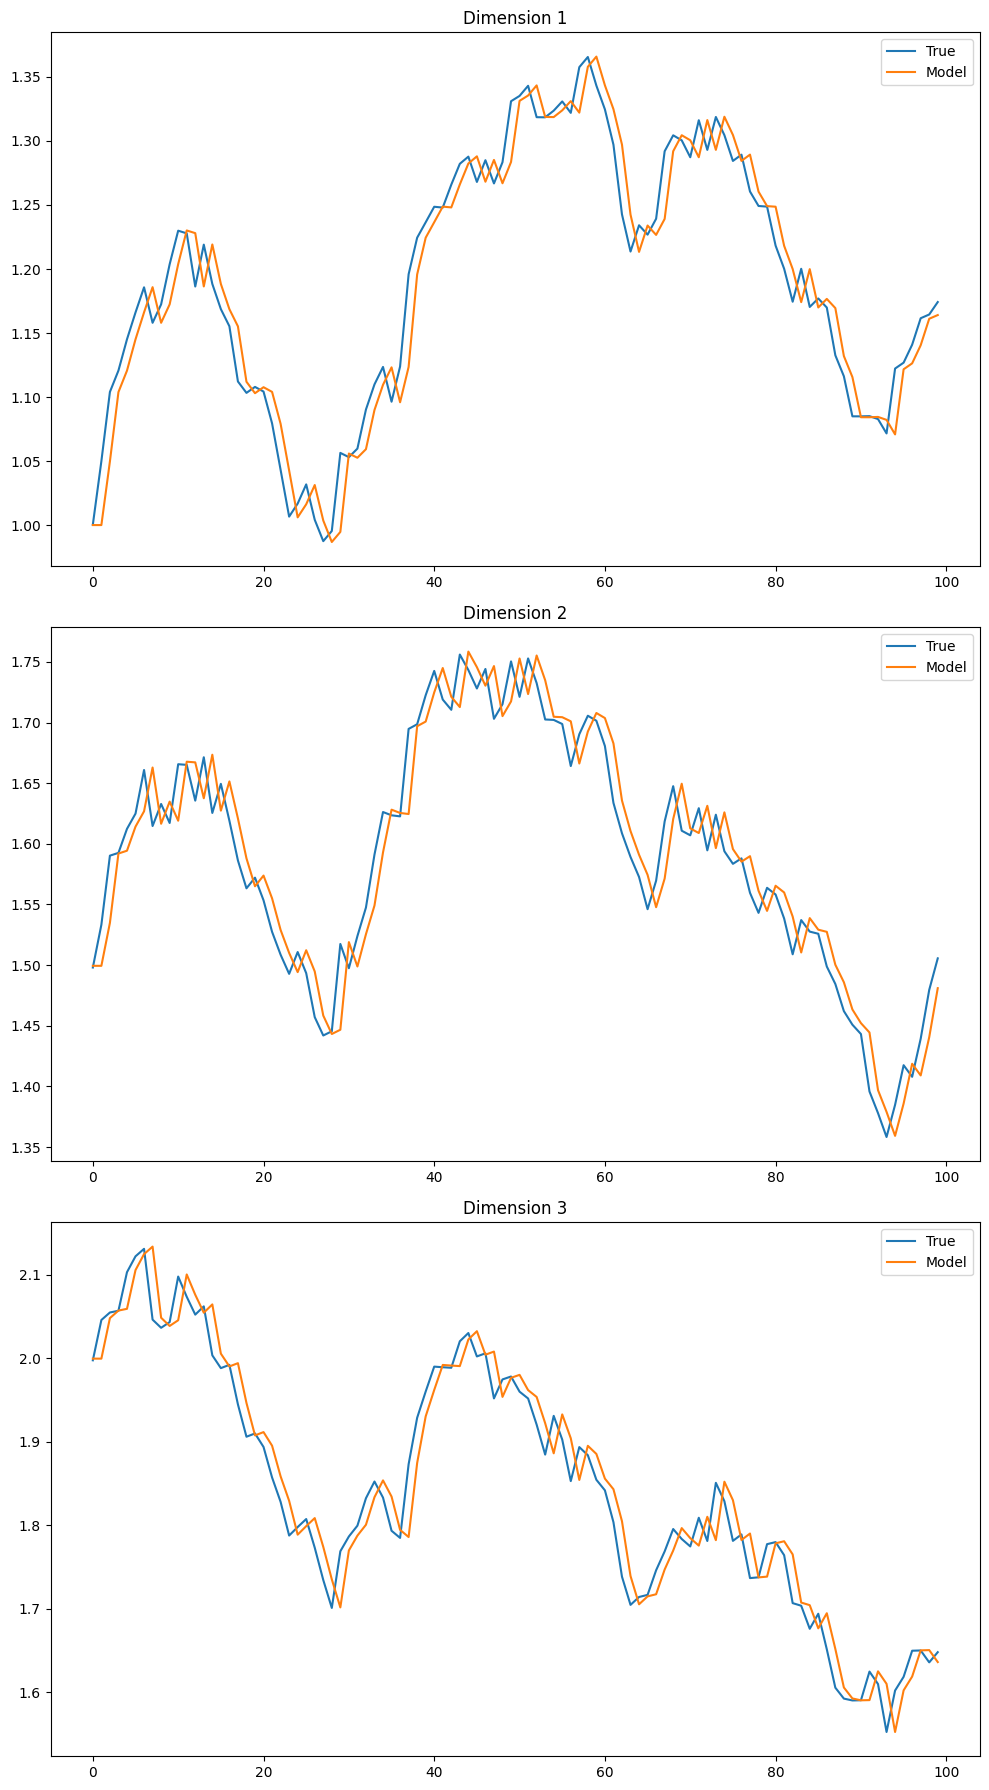

In [71]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    axs[i].plot(X_cond_true[:, i].detach().numpy(), label='True')
    axs[i].plot(X_cond_model[:,i].detach().numpy(), label='Model')
   
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

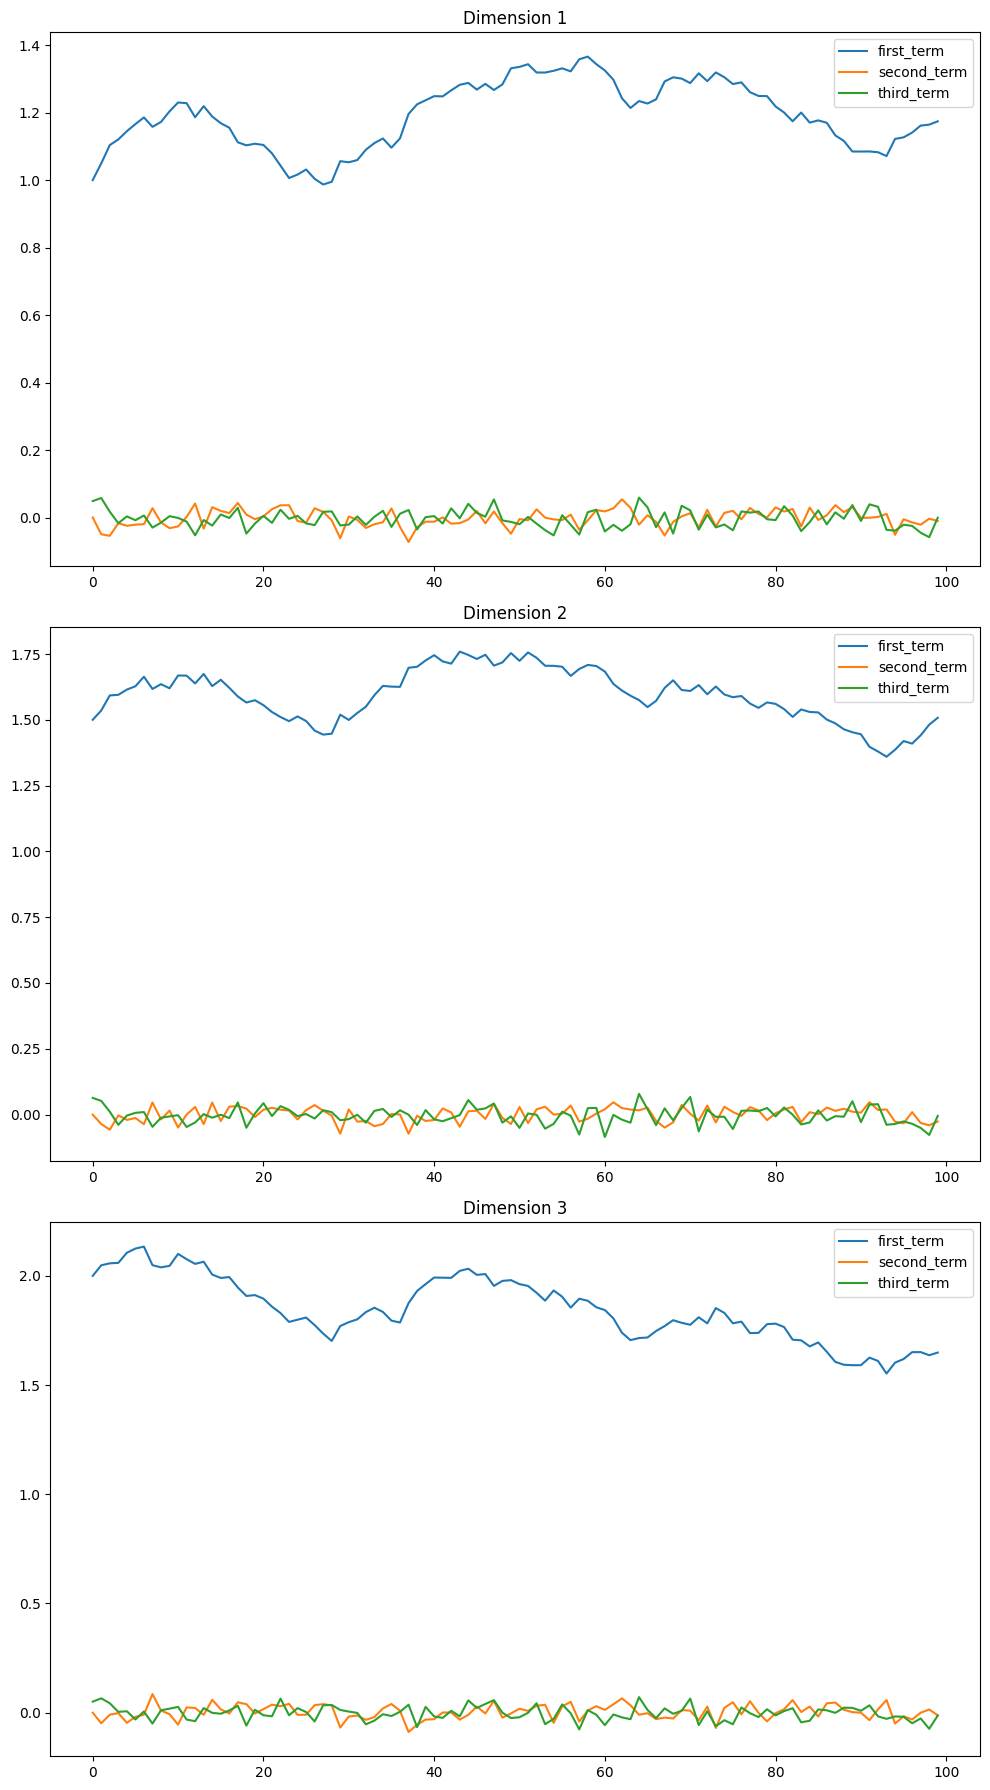

In [72]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    axs[i].plot(first_term[:165, i].detach().numpy(), label='first_term')
    axs[i].plot(second_term[:165,i].detach().numpy(), label='second_term')
    axs[i].plot(third_term[:165,i].detach().numpy(), label='third_term')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

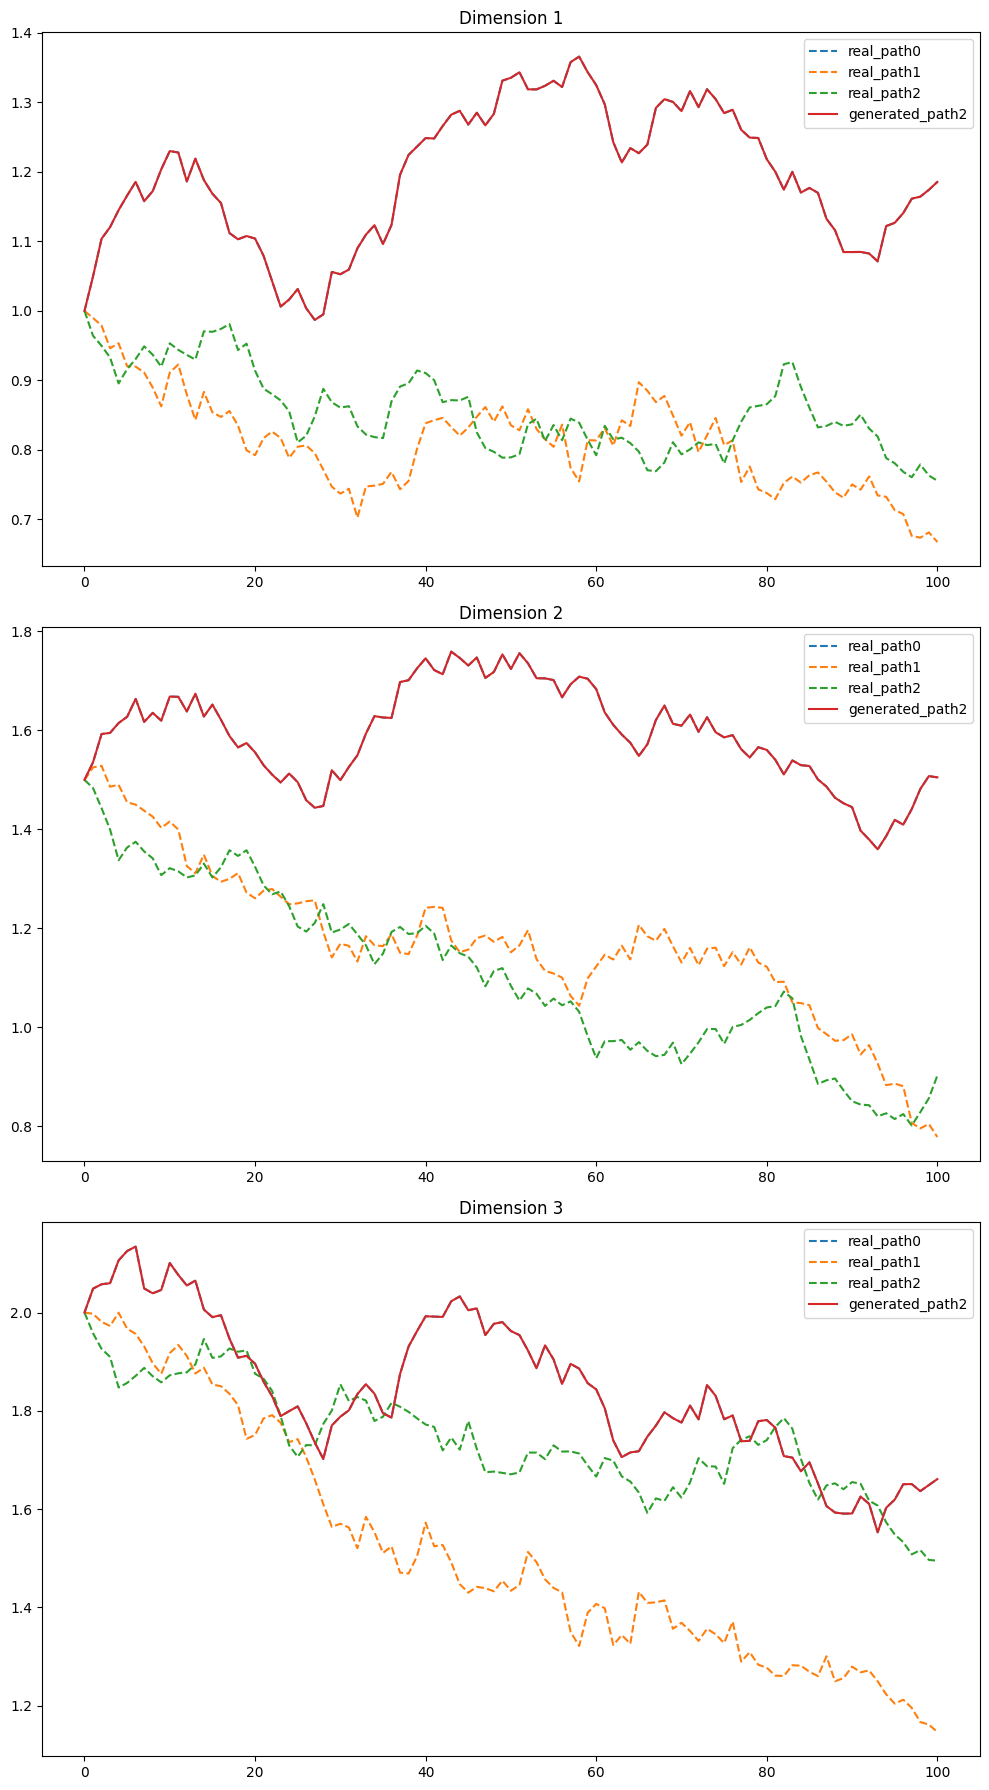

In [73]:
# Plotting each dimension separately
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    real_path = mu_data[:, i, :].T
    generated_path = X[:, i]

    for j in range(3):
        axs[i].plot(real_path[:, j], label=f'real_path{j}', linestyle="--")

    axs[i].plot(generated_path.unsqueeze(1).detach().numpy(), label=f'generated_path{j}')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

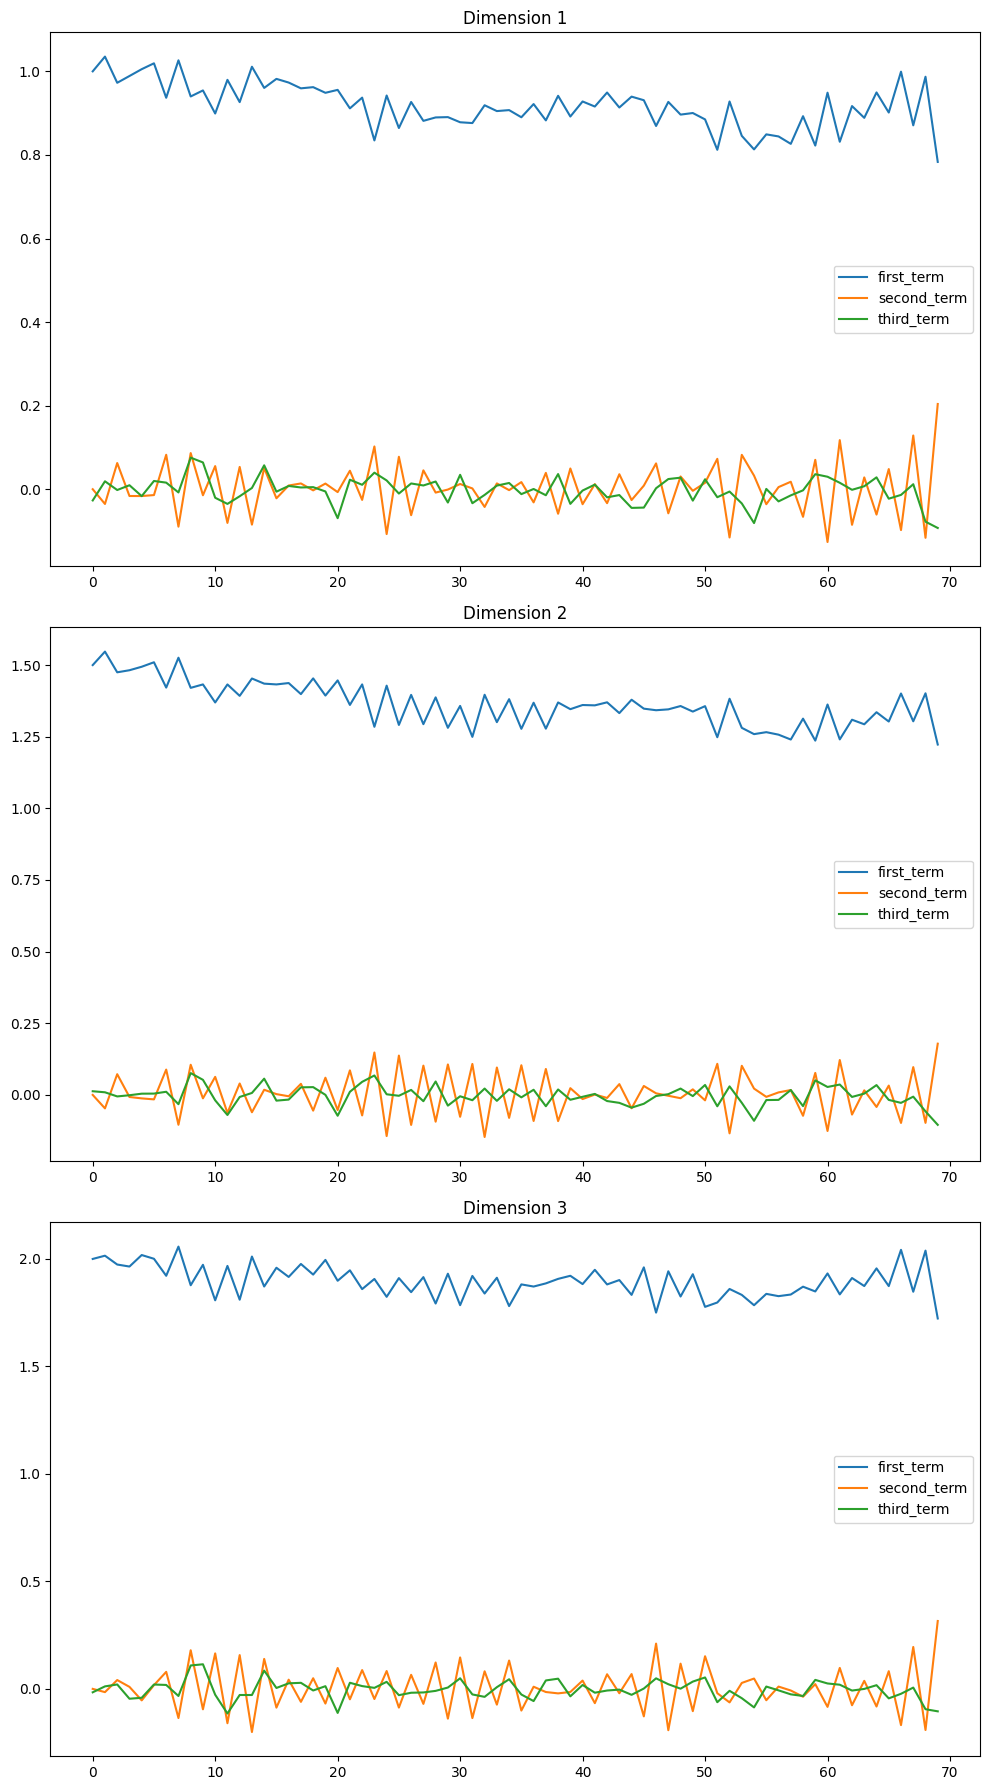

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    axs[i].plot(first_term[:70, i].detach().numpy(), label='first_term')
    axs[i].plot(second_term[:70,i].detach().numpy(), label='second_term')
    axs[i].plot(third_term[:70,i].detach().numpy(), label='third_term')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

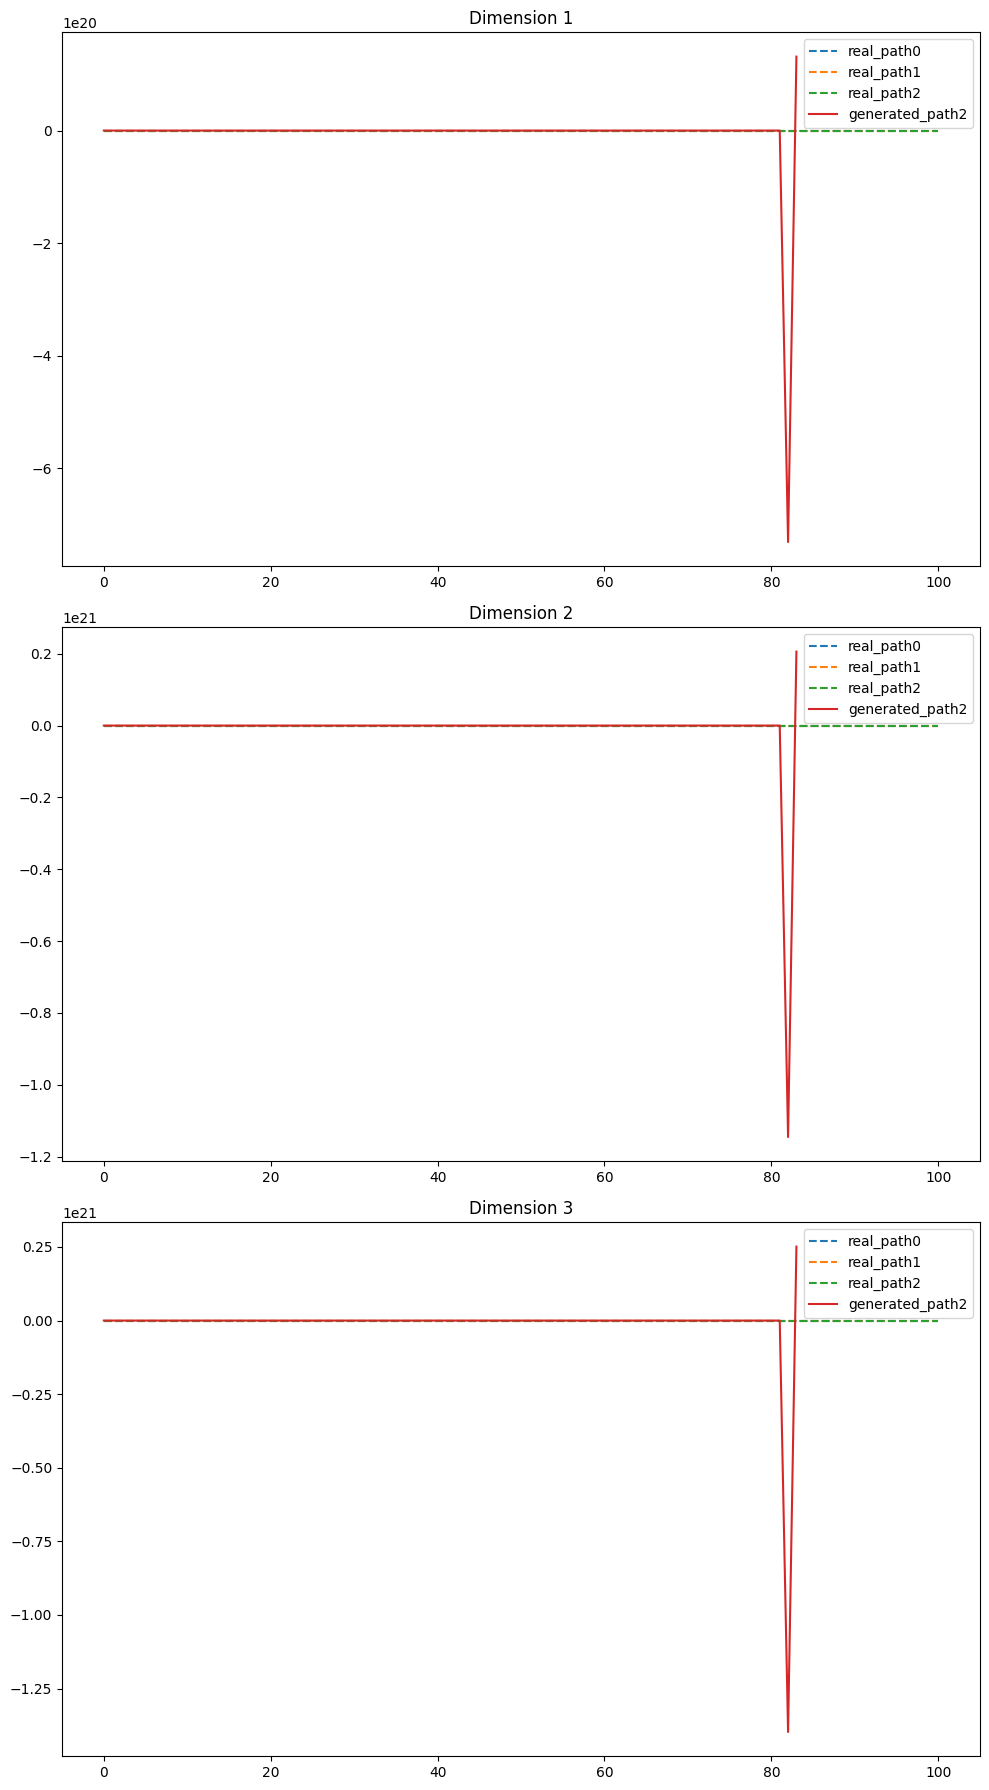

In [49]:
# Plotting each dimension separately
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    real_path = mu_data[:, i, :].T
    generated_path = X[:, i]

    for j in range(3):
        axs[i].plot(real_path[:, j], label=f'real_path{j}', linestyle="--")

    axs[i].plot(generated_path.unsqueeze(1).detach().numpy(), label=f'generated_path{j}')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

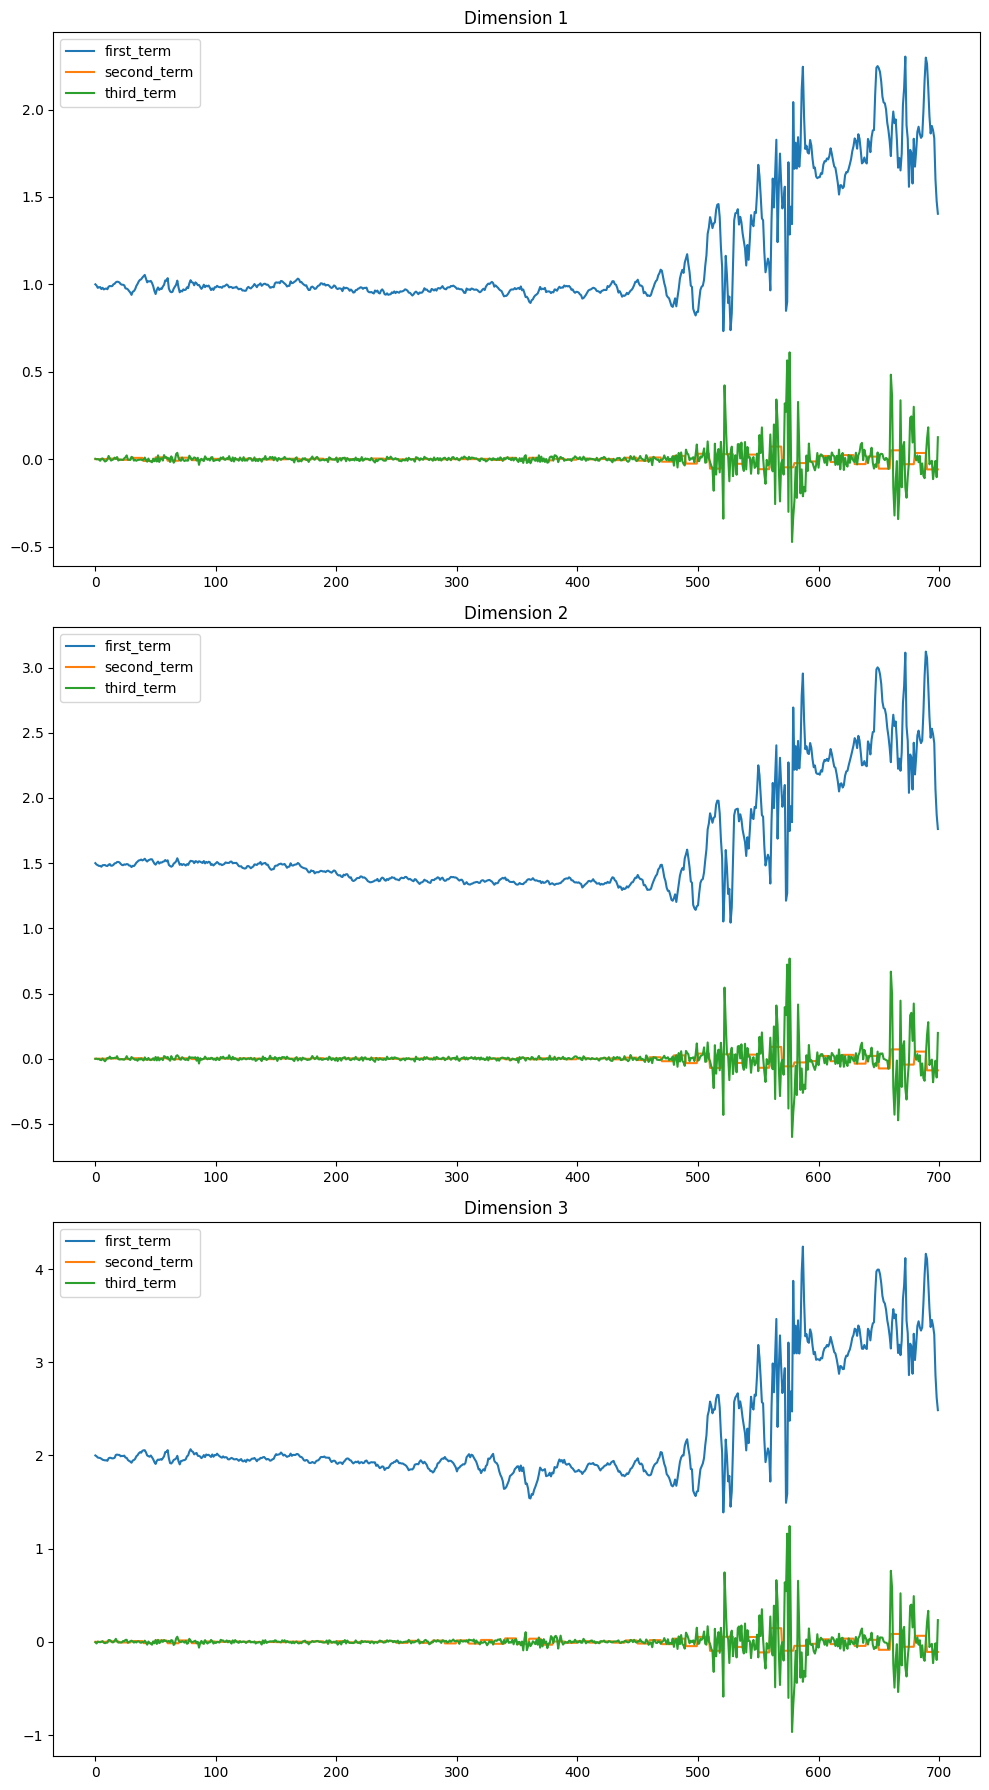

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    axs[i].plot(first_term[:700, i].detach().numpy(), label='first_term')
    axs[i].plot(second_term[:700,i].detach().numpy(), label='second_term')
    axs[i].plot(third_term[:700,i].detach().numpy(), label='third_term')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

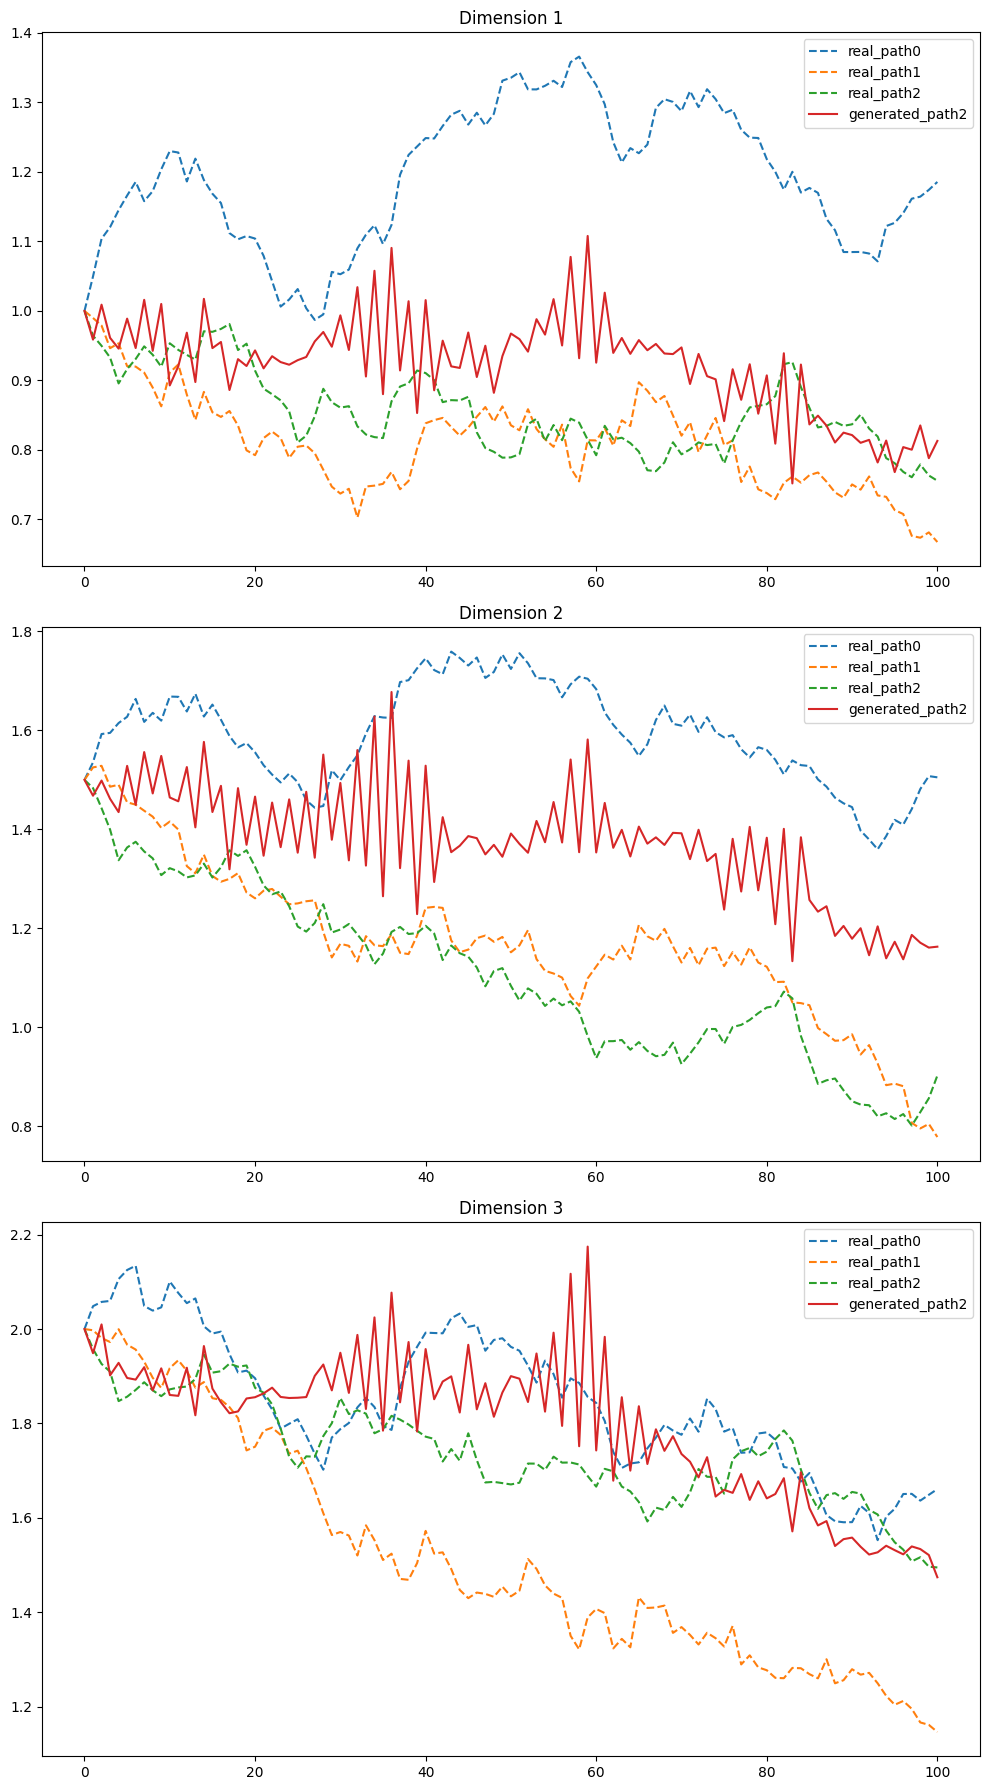

In [45]:
# Plotting each dimension separately
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    real_path = mu_data[:, i, :].T
    generated_path = X[:, i]

    for j in range(3):
        axs[i].plot(real_path[:, j], label=f'real_path{j}', linestyle="--")

    axs[i].plot(generated_path.unsqueeze(1).detach().numpy(), label=f'generated_path{j}')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

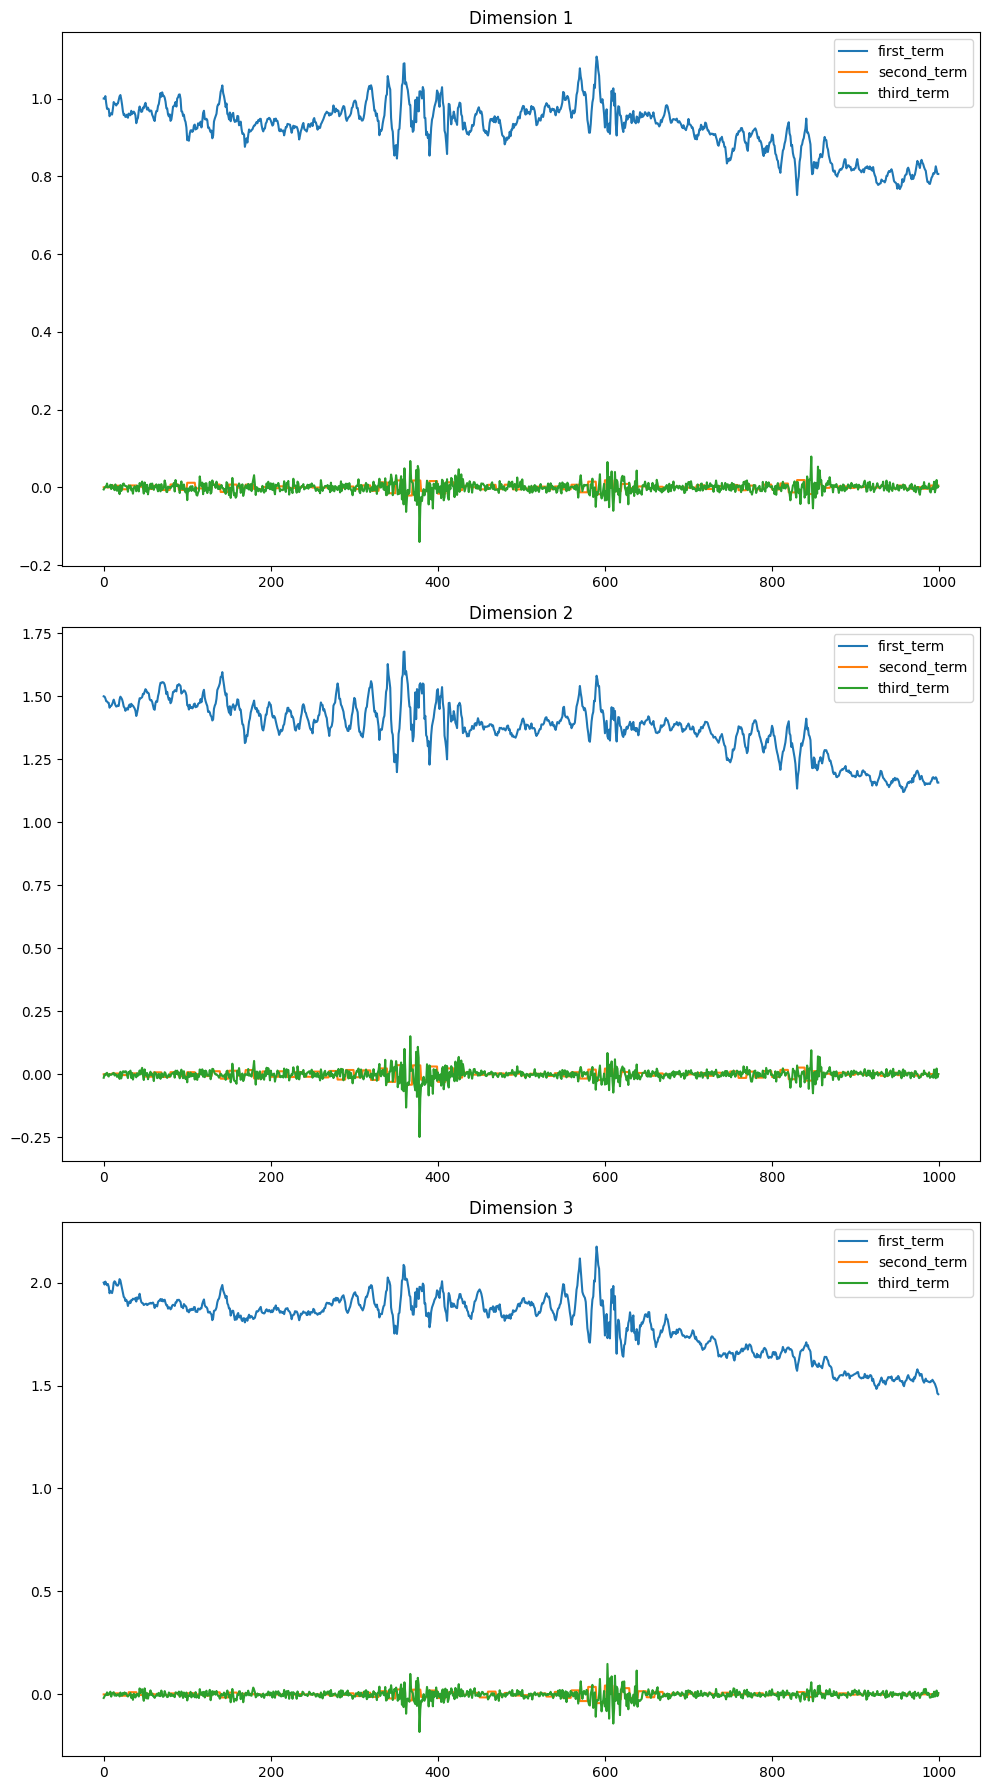

In [46]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    axs[i].plot(first_term[:, i].detach().numpy(), label='first_term')
    axs[i].plot(second_term[:,i].detach().numpy(), label='second_term')
    axs[i].plot(third_term[:,i].detach().numpy(), label='third_term')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

In [12]:
import numpy as np
from scipy.linalg import expm, solve_continuous_lyapunov
from scipy.optimize import minimize

def loglike_ou(params, paths, dt):
    """
    Negative log-likelihood for full OU.
    params: flat vector containing [vec(κ), μ (d,), vech(Σ) lower-triangular]
    paths: (M, N, d)
    """
    M, N, d = paths.shape

    # unpack
    kappa = params[:d*d].reshape(d, d)
    mu     = params[d*d:d*d + d]
    # lower-tri Σ elements:
    tril_indices = np.tril_indices(d)
    Sigma = np.zeros((d, d))
    Sigma[tril_indices] = params[d*d + d:]
    Sigma = Sigma + Sigma.T - np.diag(np.diag(Sigma))

    A = expm(-kappa * dt)
    B = (np.eye(d) - A) @ mu
    # Continuous Lyapunov solve for C:
    # Integral_0^dt e^{-κs} Σ e^{-κᵀs} ds = solve_continuous_lyapunov(κ, -Σ) - e^{-κ dt} solve_continuous_lyapunov(κ, -Σ) e^{-κᵀ dt}
    P = solve_continuous_lyapunov(kappa, -Sigma)
    C = P - A @ P @ A.T

    # accumulate
    ll = 0.0
    invC = np.linalg.inv(C)
    logdetC = np.linalg.slogdet(C)[1]
    for m in range(M):
        for n in range(N-1):
            diff = paths[m,n+1] - (A @ paths[m,n] + B)
            ll += diff @ invC @ diff
    total = 0.5 * M*(N-1)*(logdetC + d*np.log(2*np.pi)) + 0.5 * ll
    return total

def fit_ou_mle(paths, dt, initial=None):
    """
    Fit full OU via MLE.
    paths: (M,N,d)
    dt: sampling interval
    initial: optional dict with keys 'kappa','mu','Sigma' to seed optimizer
    Returns: kappa_hat (dxd), mu_hat (d,), Sigma_hat (dxd)
    """
    M, N, d = paths.shape

    # initial guess
    if initial is None:
        k0 = np.eye(d)
        mu0 = np.mean(paths.reshape(-1, d), axis=0)
        Sigma0 = np.cov(paths.reshape(-1,d).T)
    else:
        k0, mu0, Sigma0 = initial['kappa'], initial['mu'], initial['Sigma']

    # pack params
    params0 = np.concatenate([
        k0.ravel(),
        mu0,
        Sigma0[np.tril_indices(d)]
    ])

    res = minimize(loglike_ou, params0, args=(paths, dt),
                   method='L-BFGS-B')
    p = res.x

    # unpack
    kappa_hat = p[:d*d].reshape(d, d)
    mu_hat    = p[d*d:d*d + d]
    Sigma_hat = np.zeros((d,d))
    Sigma_hat[np.tril_indices(d)] = p[d*d + d:]
    Sigma_hat = Sigma_hat + Sigma_hat.T - np.diag(np.diag(Sigma_hat))

    return kappa_hat, mu_hat, Sigma_hat

if __name__ == "__main__":
    # Example usage:
    dt = 0.01
    real_paths = mu_data[1000:1100,:,:].transpose(0,2,1)
    gen_paths  = generated_paths.detach().numpy()
     
    # MLE on real
    κ_mle_real, μ_mle_real, Σ_mle_real = fit_ou_mle(real_paths, dt)
    print("MLE real κ:\n", κ_mle_real)
    print("MLE real μ:", μ_mle_real)
    print("MLE real Σ:\n", Σ_mle_real)
     
    # MLE on generated
    κ_mle_gen, μ_mle_gen, Σ_mle_gen = fit_ou_mle(gen_paths, dt)
    print("MLE gen κ:\n", κ_mle_gen)
    print("MLE gen μ:", μ_mle_gen)
    print("MLE gen Σ:\n", Σ_mle_gen)

MLE real κ:
 [[ 1.00000215e+00  2.64958320e-07  4.75933866e-07]
 [-8.57787782e-08  1.00000170e+00 -3.13381824e-07]
 [-4.58828421e-08  8.95017281e-08  1.00000202e+00]]
MLE real μ: [1.03020713 1.41136885 1.90459965]
MLE real Σ:
 [[0.008394   0.02588388 0.01839832]
 [0.02588388 0.01817367 0.03595445]
 [0.01839832 0.03595445 0.0348463 ]]
MLE gen κ:
 [[ 1.00000000e+00  7.09770412e-11  1.63469771e-10]
 [ 1.19449167e-10  1.00000000e+00 -9.90710896e-11]
 [ 1.11238582e-10  8.51229881e-11  1.00000000e+00]]
MLE gen μ: [0.93027162 1.46298897 1.89003456]
MLE gen Σ:
 [[0.03259093 0.02116027 0.02945198]
 [0.02116027 0.01416785 0.01747688]
 [0.02945198 0.01747688 0.03435992]]


In [9]:
paths = []
for j in range(10):
    times=np.array([])
    time_ptr = np.array([0])
    obs_idx = torch.tensor([],dtype=torch.long)
    start_Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
    Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
    delta_t=0.01
    X= torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
    start_X = torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
    n_obs_ot=torch.tensor([0], dtype=torch.float)
    for i in range(1,101): 
        T=0.01*i
        mu_pred=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1] 
        #print(model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot))
        X_t = X[i-1,:].unsqueeze(0) 
        if i>1: 
            X_t_minus = X[i-2, :].unsqueeze(0)
            Z_tensor = (X_t - X_t_minus).T@(X_t-X_t_minus)
            Z=torch.cat((Z,Z_tensor.view(1,-1)))
        #print(Z)
        
        sigma_pred=model_vol.get_pred(times, time_ptr, Z, obs_idx, delta_t, T, start_Z, n_obs_ot )["pred"][-1]
        
        #print(model_vol.get_pred(times, time_ptr, Z, obs_idx, delta_t, T, start_Z, n_obs_ot ))
        mu_hat_t = (mu_pred - X_t)/delta_t
        sigma_hat_t = sigma_pred/(delta_t**0.5)
        X_next = generate_next_value(X_t, mu_hat_t, sigma_hat_t.view(3,3), delta_t)
        #print(X_next, X_t, mu_hat_t*delta_t,  torch.randn_like(X_t)@sigma_pred.view(3,3))
        
        X= torch.cat((X,X_next))
        times=np.append(times, 0.01*i)
        time_ptr = np.append(time_ptr, i) 
        obs_idx=torch.cat((obs_idx, torch.tensor([0], dtype=torch.long)))
        n_obs_ot+=1
    if X.max()<5 and X.max()>-5:    
        paths.append(X)
generated_paths=torch.stack(paths)

In [10]:
generated_paths.shape

torch.Size([4, 101, 3])

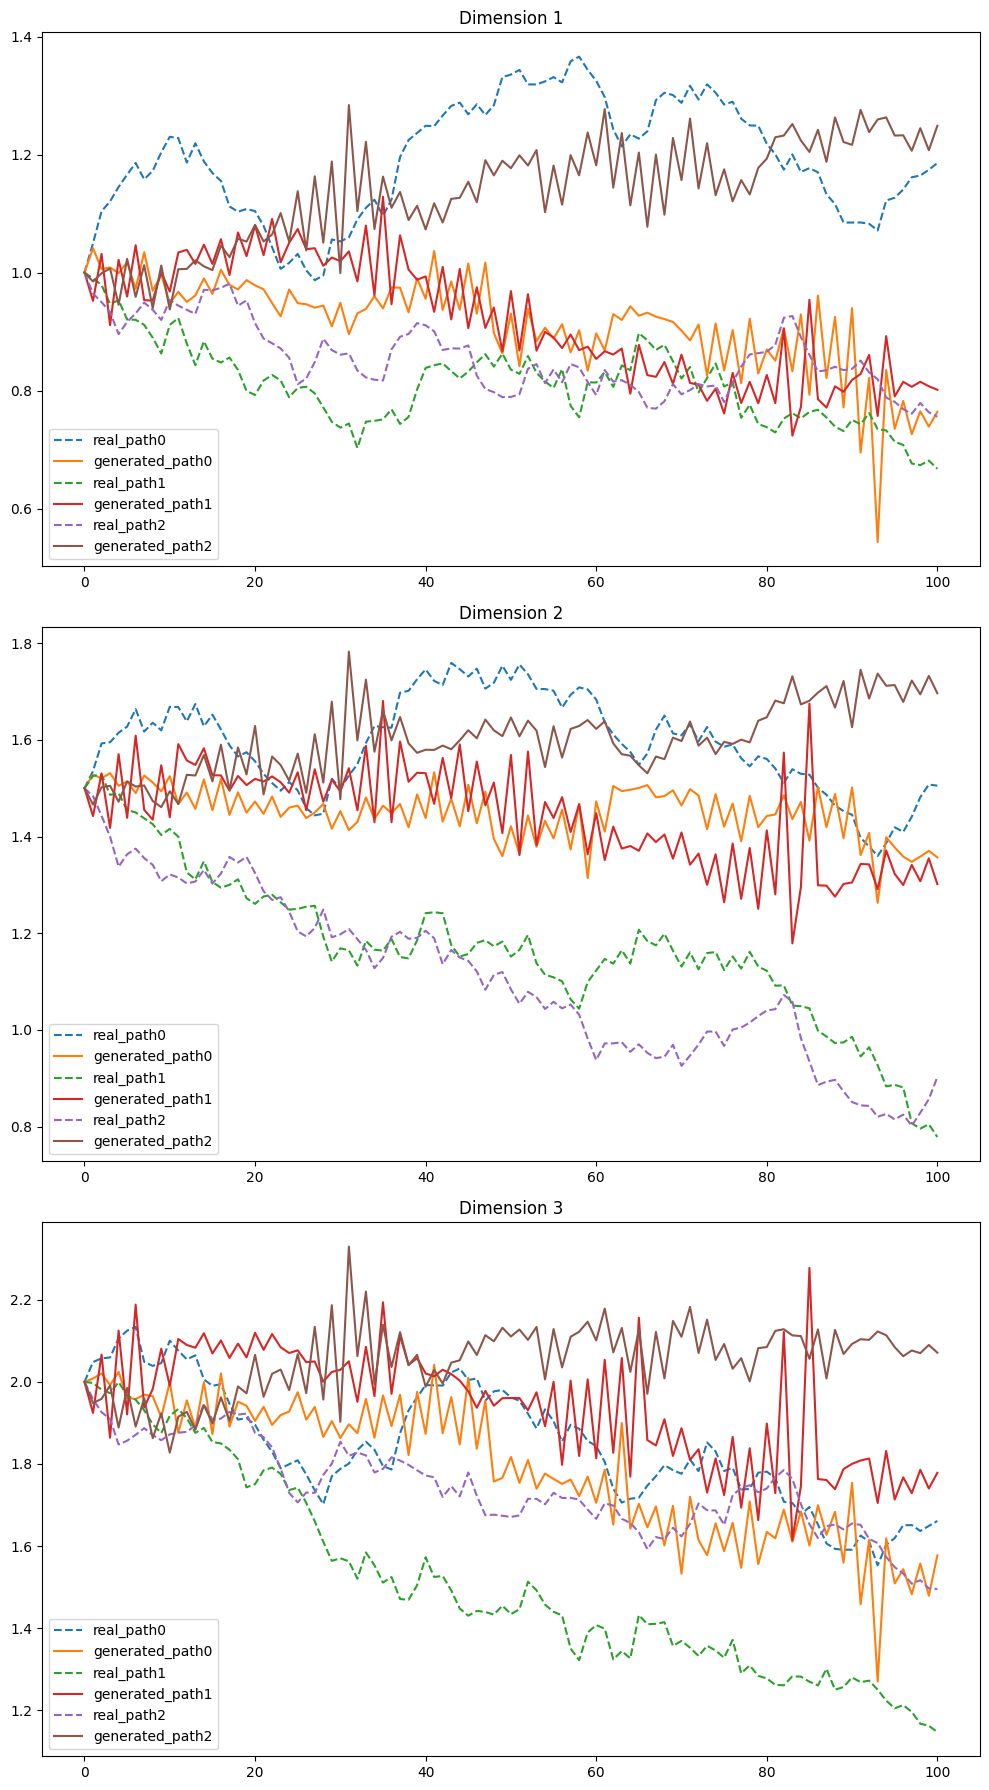

In [11]:
# Plotting each dimension separately
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    real_path = mu_data[:, i, :].T
    generated_path = generated_paths[:,:, i].T

    for j in range(3):
        axs[i].plot(real_path[:, j], label=f'real_path{j}', linestyle="--")
        axs[i].plot(generated_path[:,j].detach().numpy(), label=f'generated_path{j}')
    #axs[i].plot(generated_path.detach().numpy(), label=f'generated_path{j}')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

In [36]:
from scipy.stats import linregress
def estimate_ou_parameters(paths, delta_t):
    """
    Estimate the parameters of an OU process from given paths.
    
    Parameters:
    - paths: numpy array of shape (num_paths, num_timesteps)
    - delta_t: time increment between observations
    
    Returns:
    - theta: rate of mean reversion
    - mu: long-term mean
    - sigma: volatility
    """
    num_paths, time_steps = paths.shape



    XX = paths[:, :-1]
    YY = paths[:, 1:]
    print(XX.shape)
    
    kappa_MLE = np.empty(num_paths)
    theta_MLE = np.empty(num_paths)
    sig_MLE = np.empty(num_paths)
    
    for i in range(num_paths):
        Sx=np.sum(XX[i])
        Sy=np.sum(YY[i])
        Sxx=XX[i]@XX[i]
        Sxy=XX[i]@YY[i]
        Syy=YY[i]@YY[i]
        
        theta_MLE[i] = (Sy*Sxx-Sx*Sxy)/(time_steps*(Sxx-Syy)-(Sx**2-Sx*Sy))
        kappa_MLE[i] = (-1/delta_t)*np.log(Sxy-theta_MLE[i]*Sx-theta_MLE[i]*Sy+time_steps*theta_MLE[i]**2)/(Sxx-2*theta_MLE[i]*Sx+time_steps*theta_MLE[i]**2)
        sigma2_hat = (Syy-2*np.exp(-kappa_MLE[i]*delta_t)*Sxy + np.exp(-2*kappa_MLE[i]*delta_t)*Sxx 
                      -2*theta_MLE[i]*(1-np.exp(-kappa_MLE[i]*delta_t))*(Sy - np.exp(-kappa_MLE[i]*delta_t)*Sx)
                      +time_steps*theta_MLE[i]**2*(1-np.exp(-kappa_MLE[i]*delta_t))**2)/time_steps
        sig_MLE[i] = np.sqrt(sigma2_hat*2*kappa_MLE[i]/(1-np.exp(-2*kappa_MLE[i]*delta_t)))
    
    return np.mean(theta_MLE), np.mean(kappa_MLE), np.mean(sig_MLE)

In [38]:
from scipy.stats import linregress
def estimate_ou_parameters(paths, delta_t):
    """
    Estimate the parameters of an OU process from given paths.
    
    Parameters:
    - paths: numpy array of shape (num_paths, num_timesteps)
    - delta_t: time increment between observations
    
    Returns:
    - theta: rate of mean reversion
    - mu: long-term mean
    - sigma: volatility
    """
    num_paths, num_timesteps = paths.shape



    X_t = paths[:, :-1].flatten()
    X_t_plus_1 = paths[:, 1:].flatten()

    b, a, _, _, _ = linregress(X_t,X_t_plus_1)

    kappa_OLS = -np.log(b)/delta_t
    theta_OLS = a/(1-b)

    res=X_t_plus_1-b*X_t-a
    std_resid =np.std(res, ddof=2)

    sig_OLS = std_resid*np.sqrt(2*kappa_OLS/(1-b**2))

    return np.mean(kappa_OLS), np.mean(theta_OLS), np.mean(sig_OLS)

In [39]:
for i in range(3):
    speed_1, mean_1, volatility_1 = estimate_ou_parameters(mu_data[:2,i,:],0.01)
    #speed_2, mean_2, volatility_2 = estimate_ou_parameters(generated_paths[:,i,:].detach().numpy(),0.01)
    print( f"Dimension {i+1}" )
    print( f" Data parameters: speed = {speed_1:.3f}, mean = {mean_1:.3f}, volatility = {volatility_1:.3f}"  )
    #print( f" Generated data parameters: speed = {speed_2:.3f}, mean = {mean_2:.3f}, volatility = {volatility_2:.3f}"  )

Dimension 1
 Data parameters: speed = -0.119, mean = 1.618, volatility = 0.251
Dimension 2
 Data parameters: speed = -0.778, mean = 1.842, volatility = 0.285
Dimension 3
 Data parameters: speed = 0.520, mean = 0.533, volatility = 0.331


In [18]:
random_numbers = np.random.normal(0, 1, 3)

In [23]:
random_numbers*np.sqrt(delta_t)

array([-0.18673477, -0.05264305,  0.08852118])

In [22]:
torch.randn_like(X_t)

tensor([[-1.8788, -0.8405, -0.3901]])